In [1]:
# General modules
import sys
import os
import session_info
import warnings
from pyprojroot.here import here
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from tqdm import tqdm
# Specific modules
import scanpy as sc
import anndata as ad
import scienceplots

# Setting some parameters
warnings.filterwarnings("ignore")
sys.path.insert(1, str(here('bin')))

# Import functions
from customPythonFunctions import balanced_sample

plt.style.use(['nature'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

overwriteFigures = True
overwriteData = True

pd.options.display.max_columns=300
pd.options.display.max_rows = 1000

**Defining functions**

In [2]:
def qc_gex_projectlibrary(adata):
    import numpy as np
    import pandas as pd
    import anndata
    
    # Group the data by "project" and "library" using pandas
    grouped = adata.obs.groupby(["libraryID"])
    
    # Create an empty list to store the summary table rows
    summary_rows = []

    # Iterate over each group
    for (libraryID), group_data in grouped:
        
        # Calculate the median values within the group
        chemistry = np.unique(group_data["chemistry"])
        num_cells = group_data["libraryID"].size
        median_counts = np.median(group_data["total_counts"])
        median_features = np.median(group_data["n_genes_by_counts"])
        median_mt_pct = np.median(group_data["pct_counts_mt"])
        median_ribo_pct = np.median(group_data["pct_counts_ribo"])
        median_hb_pct = np.median(group_data["pct_counts_hb"])
        median_plt_pct = np.median(group_data["pct_counts_plt"])
    
        # Create a summary row with the group information and median values
        summary_row = {
            "libraryID": libraryID,
            "chemistry": chemistry,
            "Number of cells": int(num_cells),
            "Median UMI counts": int(median_counts),
            "Median Genes": int(median_features),
            "Median MT %": round(median_mt_pct, 2),
            "Median RB %": round(median_ribo_pct,2),
            "Median HB %": round(median_hb_pct,2),
            "Median PLT %": round(median_plt_pct,2),
        }

        # Append the summary row to the list
        summary_rows.append(summary_row)

    # Create a DataFrame from the summary rows
    summary_table = pd.DataFrame(summary_rows)
    return summary_table
    
def qc_gene_expression_per_study(adata, gene_list = None, save_name=None, fig_size = (20,4)):
    import numpy as np
    import pandas as pd
    import anndata
    import sys
    import seaborn as sns
    
    if gene_list is None:
        gene_list = adata.var_names
    
    res = pd.DataFrame(columns=gene_list, index=adata.obs['studyID'].unique())
    
    for source in adata.obs['studyID'].unique(): 
        res.loc[source] = adata[adata.obs['studyID'].isin([source]),gene_list].X.mean(0)
    
    BinRes = res.copy()
    BinRes[BinRes > 0 ] = 1.0
    
    sys.setrecursionlimit(50000)
    sns.clustermap(BinRes.astype(float), z_score=None, figsize=fig_size)

    if save_name:
        plt.savefig(here(save_name), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    plt.show()

In [3]:
print("EXTERNAL directory path: {}".format(here()))

# create result directories
os.makedirs(here('01_data_processing/SCGT00_CentralizedDataset/results/extended_obs'), exist_ok = True)
os.makedirs(here('01_data_processing/SCGT00_CentralizedDataset/figures'), exist_ok=True)

EXTERNAL directory path: /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas-R1


**Load data**

In [4]:
# Load the h5ad file
infile_path = here("01_data_processing/SCGT00_CentralizedDataset/results/SCGT00_EXTERNAL.h5ad")
adata = sc.read_h5ad(infile_path)
adata

AnnData object with n_obs × n_vars = 392847 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

In [5]:
adata.obs.head()

,studyID,libraryID,sampleID,chemistry,technology,patientID,disease,timepoint_replicate,treatmentStatus,therapyResponse,sex,age,BMI,binned_age,diseaseStatus,smokingStatus,ethnicity,institute,diseaseGroup,batches
cellID,,,,,,,,,,,,,,,,,,,,
SCGT00_L028_I5015.3P_T0_AAACCCAAGACGATAT,SCGT00,SCGT00_L028,SCGT00_I5015.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I5015,RA,0.0,ongoing,NR,female,58.0,36.73,51-60,na,never-smoker,na,na,IMIDs,RA_Pool5Pool7
SCGT00_L028_I5017.3P_T0_AAACCCAAGGTGGTTG,SCGT00,SCGT00_L028,SCGT00_I5017.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I5017,RA,0.0,ongoing,NR,female,22.0,19.49,18-30,na,never-smoker,na,na,IMIDs,RA_Pool5Pool7
SCGT00_L028_I5013.3P_T0_AAACCCACAATCTCGA,SCGT00,SCGT00_L028,SCGT00_I5013.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I5013,RA,0.0,ongoing,NR,female,44.0,30.43,41-50,na,smoker,na,na,IMIDs,RA_Pool5Pool7
SCGT00_L028_I5017.3P_T0_AAACCCACACTCCCTA,SCGT00,SCGT00_L028,SCGT00_I5017.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I5017,RA,0.0,ongoing,NR,female,22.0,19.49,18-30,na,never-smoker,na,na,IMIDs,RA_Pool5Pool7
SCGT00_L028_I5020.3P_T0_AAACCCACATCGGCCA,SCGT00,SCGT00_L028,SCGT00_I5020.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I5020,RA,0.0,ongoing,R,female,60.0,20.28,51-60,na,never-smoker,na,na,IMIDs,RA_Pool5Pool7


In [6]:
adata.var.head()

,hgnc_id,symbol,locus_group,HUGO_status
ensembl_gene_id,,,,
ENSG00000000003,HGNC:11858,TSPAN6,protein_coding,official
ENSG00000000005,HGNC:17757,TNMD,protein_coding,official
ENSG00000000419,HGNC:3005,DPM1,protein_coding,official
ENSG00000000457,HGNC:19285,SCYL3,protein_coding,official
ENSG00000000460,HGNC:25565,FIRRM,protein_coding,official


**Load metadata**

In [7]:
datasetDF = pd.read_csv(here('00_data_processing/datasets/INFLAMMATION_ATLAS_datasets_curated.csv'))
datasetDF.set_index('studyID', inplace=True)
datasetDF

,diseaseGroup,disease,dataSource,h5ad_FileName,ENSEMBLGeneID,externalValidation,chemistry,technology,cellrangerVersion,genomeVersion,expectedDoubletRate
studyID,,,,,,,,,,,
SCGT00,homeostasis;IMID,HC;RA;PsA;IBDs_CD;IBDs_UC;PS;SLE,inhouse,INFLAMMATION_SCGT00_week0_bothChemistry_merged...,YES,NO,mixed,mixed_GenoHashed,v6.1.1_NoIntrons,GRCh38_v32/Ensembl98,0.02
SCGT00val,IMID,RA,inhouse,INFLAMMATION_SCGT00validation_week0_merged.h5ad,YES,YES,3_GEX_V3,3_GEX_V3_GenoHashed,v6.1.1_NoIntrons,GRCh38_v32/Ensembl98,0.02
SCGT01,homeostasis,HC,inhouse,INFLAMMATION_EXERCISEHC_merged.h5ad,YES,NO,3_GEX_V3,3_GEX_V3_CellPlex,v6.1.1_NoIntrons,GRCh38_v32/Ensembl98,0.02
SCGT02,homeostasis;chronic_inflammation,HC;Asthma;COPD,inhouse,INFLAMMATION_ASTHMA-COPD-HC_merged.h5ad,YES,NO,3_GEX_V3,3HT_GEX_V3_GenoHashed,v6.1.1_NoIntrons,GRCh38_v32/Ensembl98,0.01
SCGT03,solid_tumors,BRCA,inhouse,INFLAMMATION_BRCA_time0_merged.h5ad,YES,NO,5_GEX_V2,5_GEX_V2,v6.1.1_NoIntrons,GRCh38_v32/Ensembl98,0.08
SCGT04,chronic_inflammation,cirrhosis,inhouse,INFLAMMATION_CIRRHOSIS_merged.h5ad,YES,NO,3_GEX_V3,3HT_GEX_V3_CellPlex,v6.1.1_NoIntrons,GRCh38_v32/Ensembl98,0.01
SCGT05,solid_tumors,CRC,inhouse,INFLAMMATION_CRC_merged.h5ad,YES,NO,5_GEX_V2,5_GEX_V2,v6.1.2_NoIntrons,GRCh38_v32/Ensembl98,0.08
SCGT06,homeostasis;infection,HC;COVID,inhouse,INFLAMMATION_COVID-HC_merged.h5ad,YES,YES,3_GEX_V3,3HT_GEX_V3_GenoHashed,v6.1.1_NoIntrons,GRCh38_v32/Ensembl98,0.01
Reyes2020,homeostasis;acute_inflammation,HC;sepsis,public,Reyes_NatMed_2020__Sepsis-HC.h5ad,NO,NO,3_GEX_V2,3_GEX_V2_Hashed,v2.1_NoIntrons,GRCh38/Ensembl87,0


# Quality control

## Compute QC covariates

First, we will compute the QC covariates (fraction of mitochondrial, ribosomal and hemoglobine genes) on our data.

In [8]:
# mitochondrial genes
adata.var["mt"] = adata.var["symbol"].str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var["symbol"].str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var["symbol"].str.contains("^HB[^(P)]")
# platelet genes
adata.var["plt"] = adata.var["symbol"].isin(["PPBP", "PDGF", "ANG1", "LAPTM4B", "WASF3", "TPM3", "PF4", "TAC1"])

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb", "plt"], inplace=True, percent_top=[20], log1p=True)
adata

AnnData object with n_obs × n_vars = 392847 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [9]:
pd.set_option('display.max_rows', None)
qc_gex_df = qc_gex_projectlibrary(adata)
display(qc_gex_df)

pd.reset_option('display.max_rows')

,libraryID,chemistry,Number of cells,Median UMI counts,Median Genes,Median MT %,Median RB %,Median HB %,Median PLT %
0,"(SCGT00_L003,)",[3_GEX_V3],29124,3452,1048,8.56,32.44,0.00,0.04
1,"(SCGT00_L010,)",[3_GEX_V3],28185,3684,1164,7.20,33.77,0.00,0.05
2,"(SCGT00_L013,)",[3_GEX_V3],19641,3440,1098,7.49,33.79,0.00,0.04
3,"(SCGT00_L016,)",[3_GEX_V3],20934,4258,1291,5.99,26.41,0.00,0.06
4,"(SCGT00_L024,)",[3_GEX_V3],28697,3481,1057,7.11,36.76,0.00,0.05
5,"(SCGT00_L026,)",[3_GEX_V3],25342,3583,1150,4.11,38.15,0.00,0.03
6,"(SCGT00_L028,)",[3_GEX_V3],26236,3712,1160,6.38,26.68,0.00,0.06
7,"(SCGT00_L030,)",[3_GEX_V3],29571,2790,926,8.64,29.50,0.00,0.04
8,"(SCGT00_L037,)",[3_GEX_V3],20536,3820,1175,6.74,36.23,0.00,0.04
9,"(SCGT00_L043,)",[3_GEX_V3],28309,2650,1015,5.78,29.30,0.00,0.04


# Quality control at LIBRARY level

After exploring general library QC metrics, we decided to filter out the libraries with very low quality, considering the total number of cells (standard 10X channel is designed to target 2-10K cells) and the median number of total genes (recovering information for very few genes might become a problem in the downstream analysis steps). 

In [10]:
# QC thresholds
min_cells_by_lib = 500
min_meangenes_by_lib = 500

In [11]:
# Removing libraries with very low total number of cells

# Calculate the value counts for each 'libraryID'
library_cells = adata.obs["libraryID"].value_counts()

# Get the library names to remove
libraries_to_remove = library_cells[library_cells < min_cells_by_lib].index

if len(libraries_to_remove) > 0:
    print('Libraries removed:')
    print(libraries_to_remove.astype(str))

    # Filter the 'adata' object
    adata = adata[~adata.obs["libraryID"].isin(libraries_to_remove.astype(str))]
else:
    print('No library is removed')

No library is removed


In [12]:
# Removing libraries with very low median number of total genes

# Calculate the median total counts for each 'libraryID'
library_median_counts = adata.obs.groupby("libraryID")["n_genes_by_counts"].median()

# Get the library names with median "total_counts" fewer than 500
libraries_to_remove = library_median_counts[library_median_counts < min_meangenes_by_lib].index

if len(libraries_to_remove) > 0:
    print('Libraries removed:')
    print(libraries_to_remove.astype(str))

    # Filter the 'adata' object
    adata = adata[~adata.obs["libraryID"].isin(libraries_to_remove.astype(str))]
else:
    print('No library is removed')

No library is removed


# Quality control at CELL level

We aim to remove low-quality cells from the dataset focusing on the EXTERNAL three QC metrics, but also two additional QC covariates interesting:

1. Library size: Number of counts or UMIs per barcode
2. Library complexity: Number of genes per barcode
3. Fraction of counts from mitochondrial genes per barcode
4. (Fraction of counts from ribosomal genes per barcode)
5. (Fraction of counts from hemoglobine genes per barcode)

Following best practices: https://www.sc-best-practices.org/preamble.html

Luecken, M. D., & Theis, F. J. (2019). Current best practices in single‐cell RNA‐seq analysis: a tutorial. Molecular systems biology, 15(6), e8746

## Assessing QC information

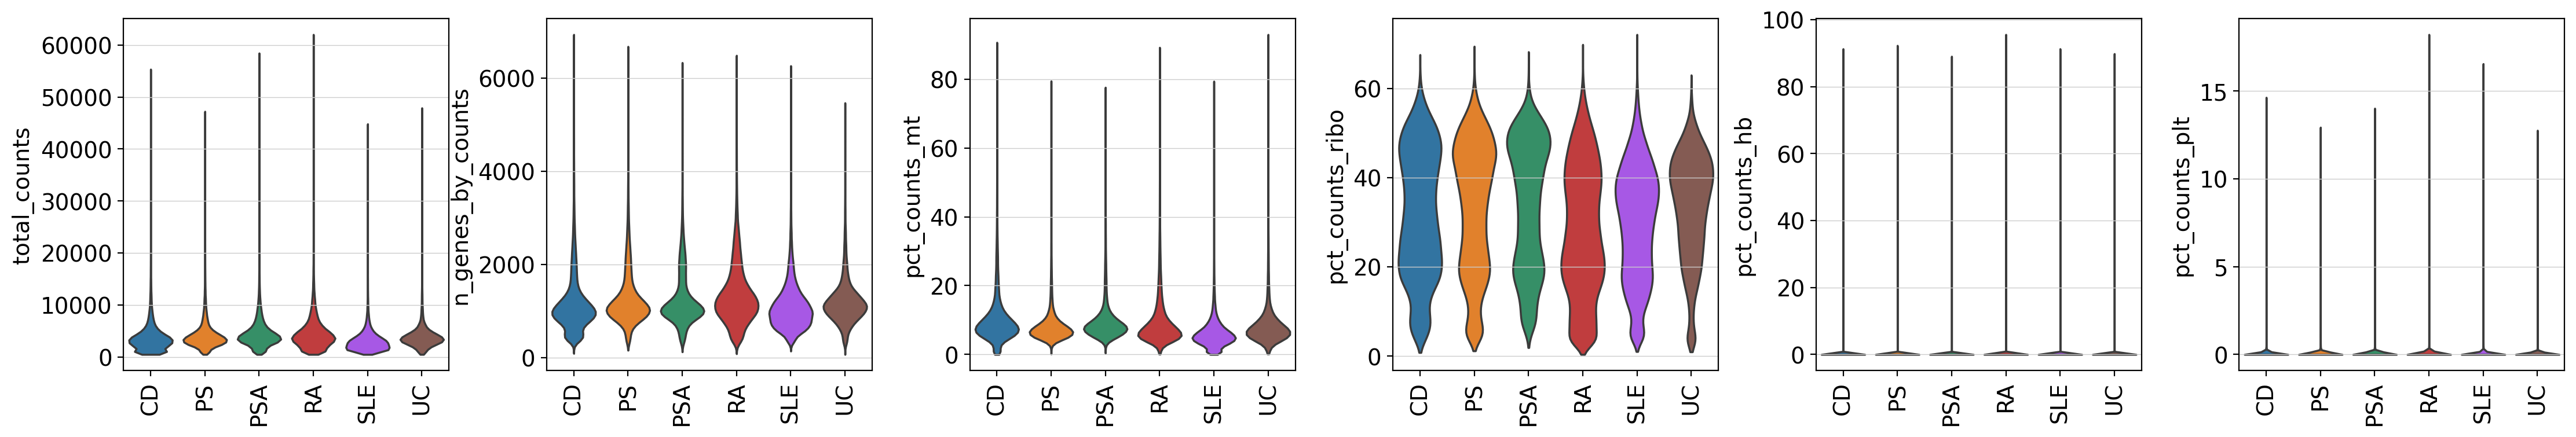

<Figure size 400x400 with 0 Axes>

In [13]:
sc.pl.violin(
    adata, 
    [
     'total_counts', 
     'n_genes_by_counts', 
     'pct_counts_mt',
     'pct_counts_ribo',
     'pct_counts_hb',
     'pct_counts_plt'
    ],
    groupby="disease", 
    stripplot=False, rotation = 90,
)

if overwriteFigures:
    plt.savefig(here('01_data_processing/SCGT00_CentralizedDataset/figures/QC_EXTERNAL_totalCount_by_disease.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    
plt.show()

NON prefiltered studies | 3_GEX_V3


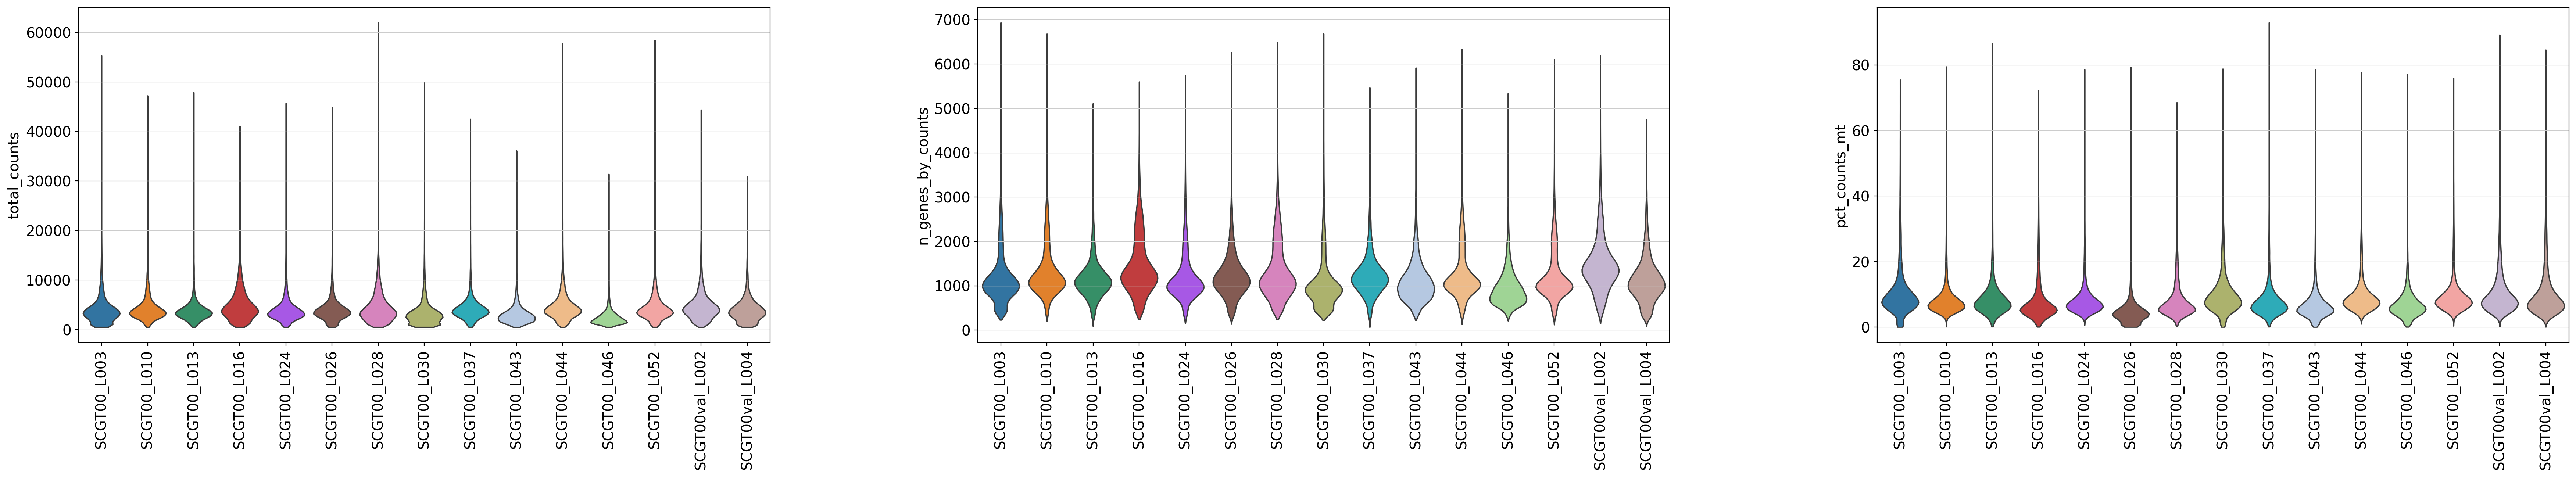

<Figure size 1000x600 with 0 Axes>

In [14]:
preFilterCellsIdx = adata.obs.studyID.isin(datasetDF.loc[datasetDF.expectedDoubletRate == '0'].index.tolist())

with plt.rc_context({'figure.figsize':(10,6)}):
    cellIdx = (adata.obs.chemistry == "3_GEX_V3") & (preFilterCellsIdx)
    if np.sum(cellIdx) > 0:
        print('prefiltered studies | 3_GEX_V3')
        sc.pl.violin(adata[cellIdx, :],
                     keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], 
                     groupby='libraryID', 
                     stripplot=False,
                     rotation=90, show = False,
                     #title="3_GEX_V3"
                    )
        if overwriteFigures:
            plt.savefig(here('01_data_processing/SCGT00_CentralizedDataset/figures/QC_EXTERNAL_metrics_3GEXV3cleaned_totCount_byLibrary.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
        plt.show()
        
    cellIdx = (adata.obs.chemistry == "3_GEX_V3") & (~preFilterCellsIdx)
    if np.sum(cellIdx) > 0:
        print('NON prefiltered studies | 3_GEX_V3')
        sc.pl.violin(adata[cellIdx, :],
                     keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], 
                     groupby='libraryID', 
                     stripplot=False,
                     rotation=90,
                     # title="3_GEX_V3"
                    )
        if overwriteFigures:
            plt.savefig(here('01_data_processing/SCGT00_CentralizedDataset/figures/QC_EXTERNAL_metrics_3GEXV3notCleaned_totCount_byLibrary.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
        plt.show()     

Next, we visualize the QC variables across libraries (considering the library' chemistry) and assess their overall quality based on the metrics to decide how to proceed with the QC step.

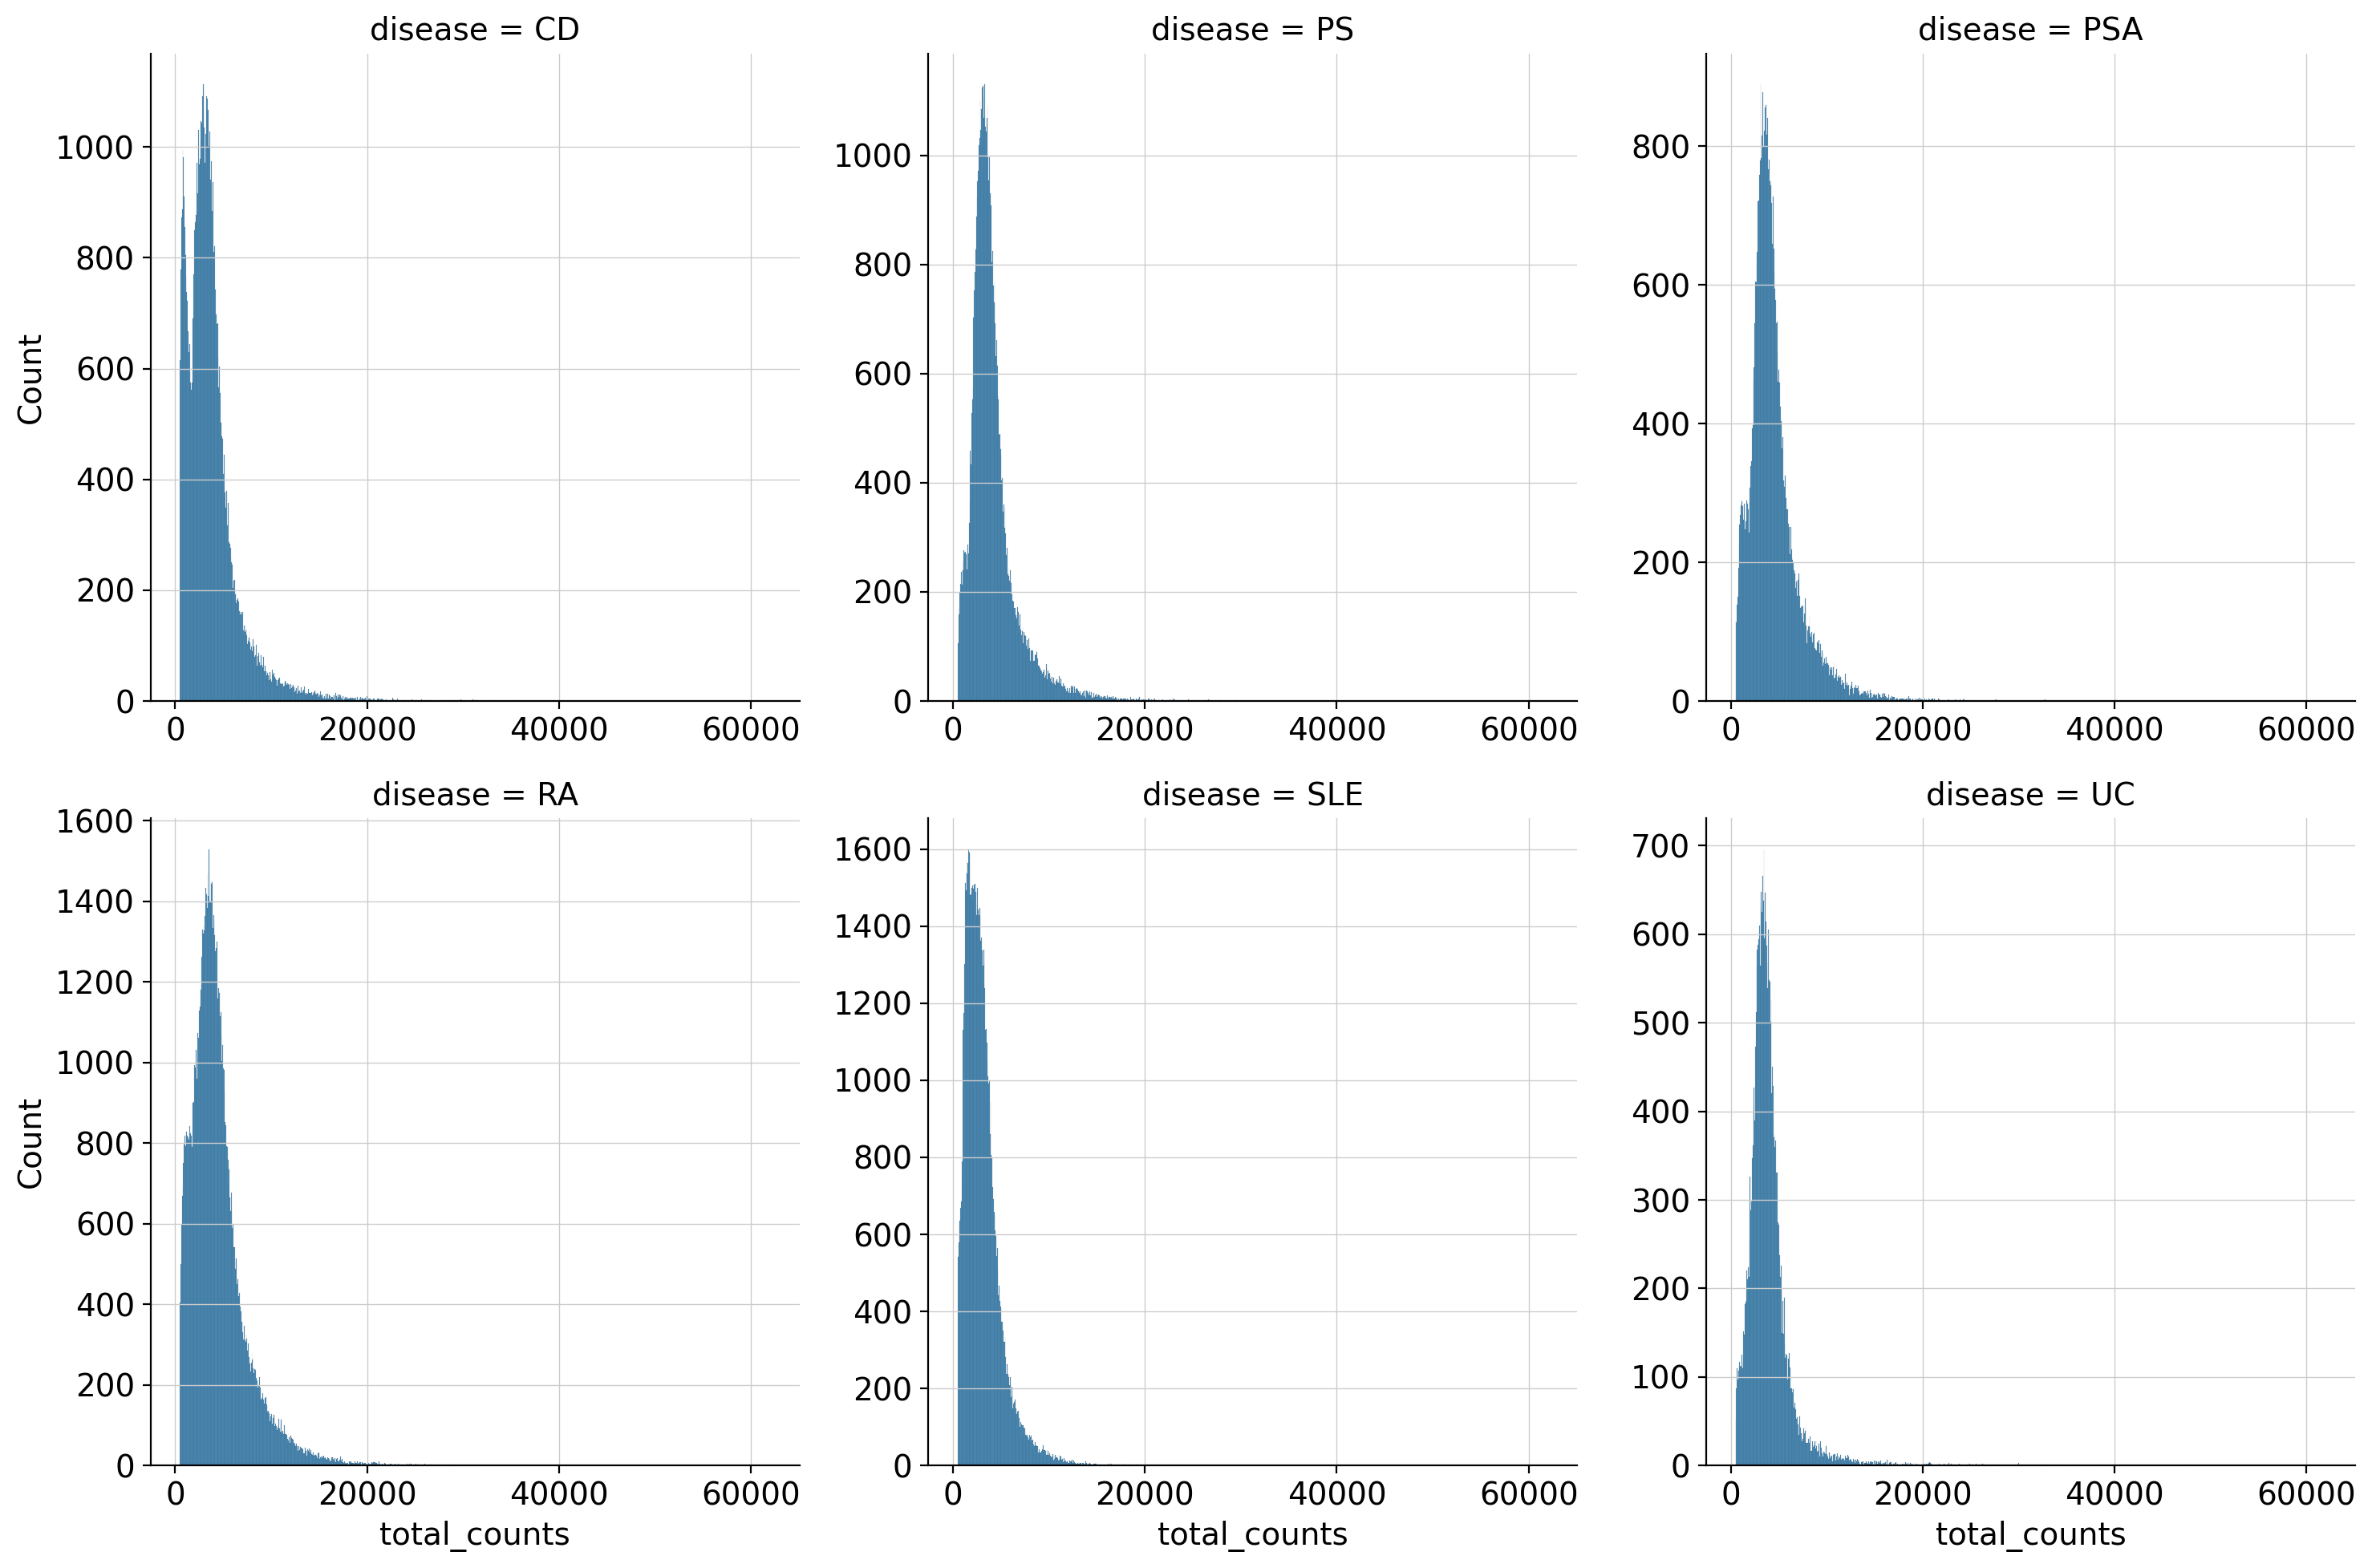

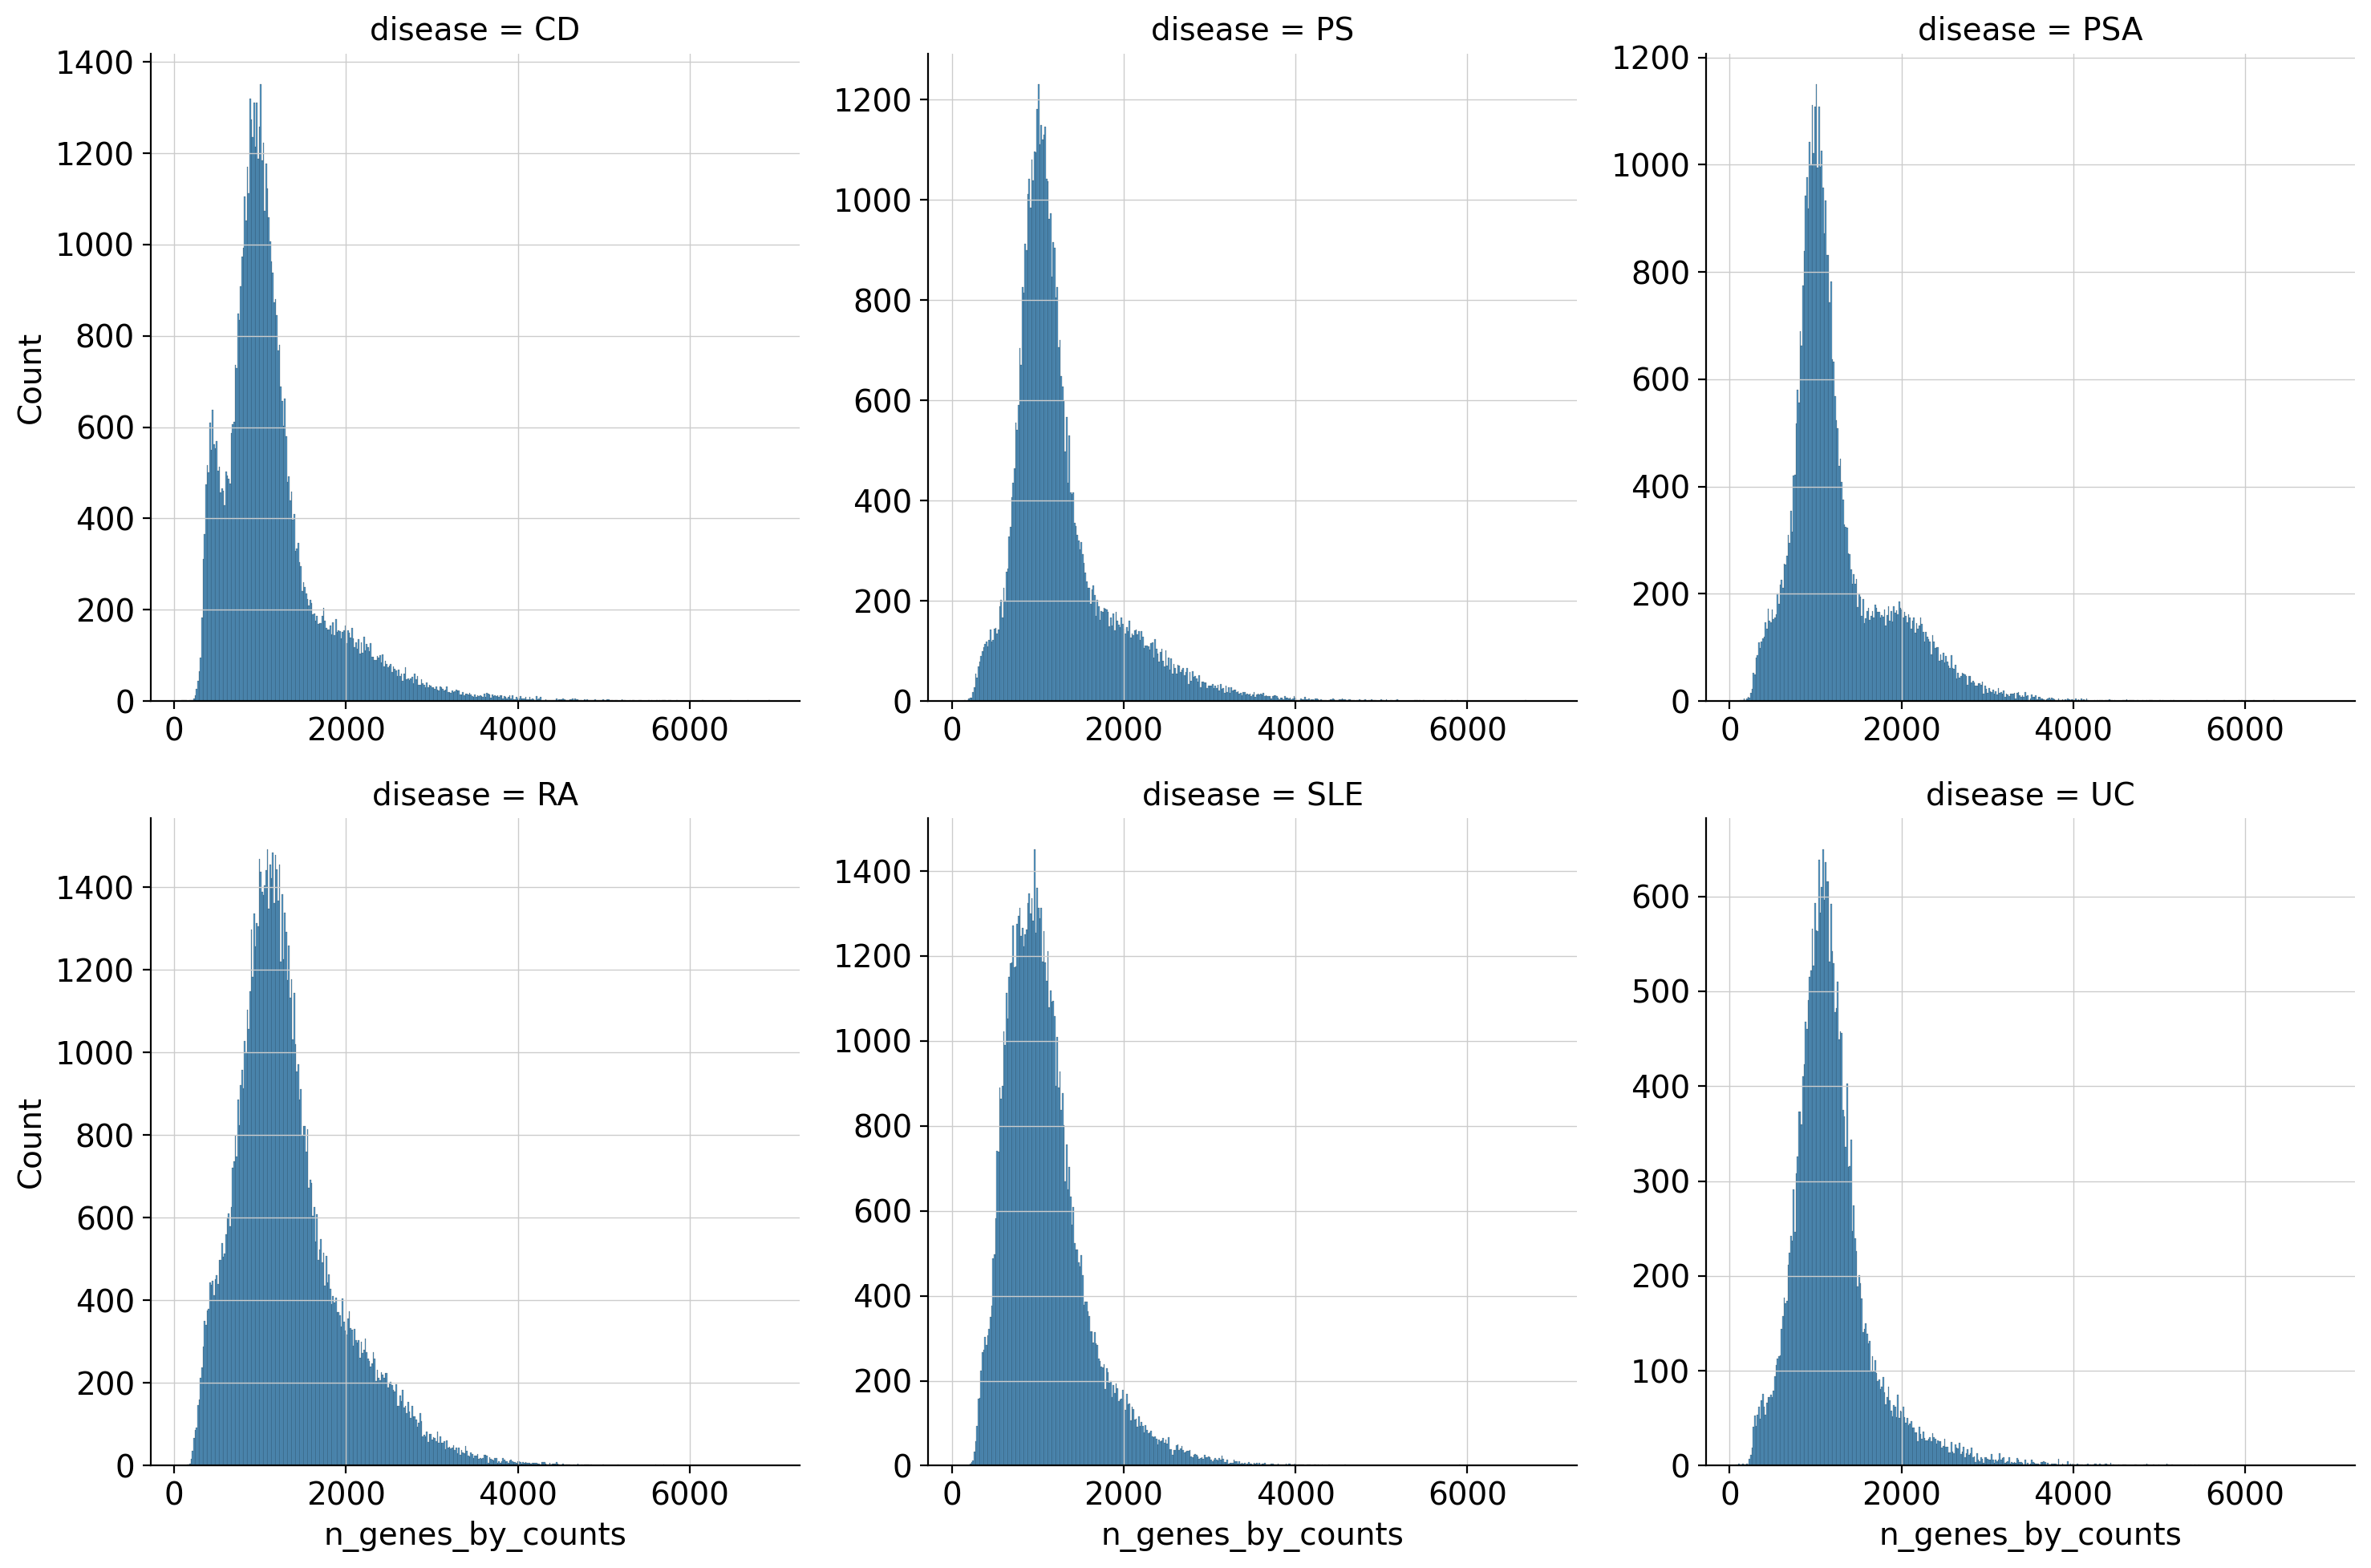

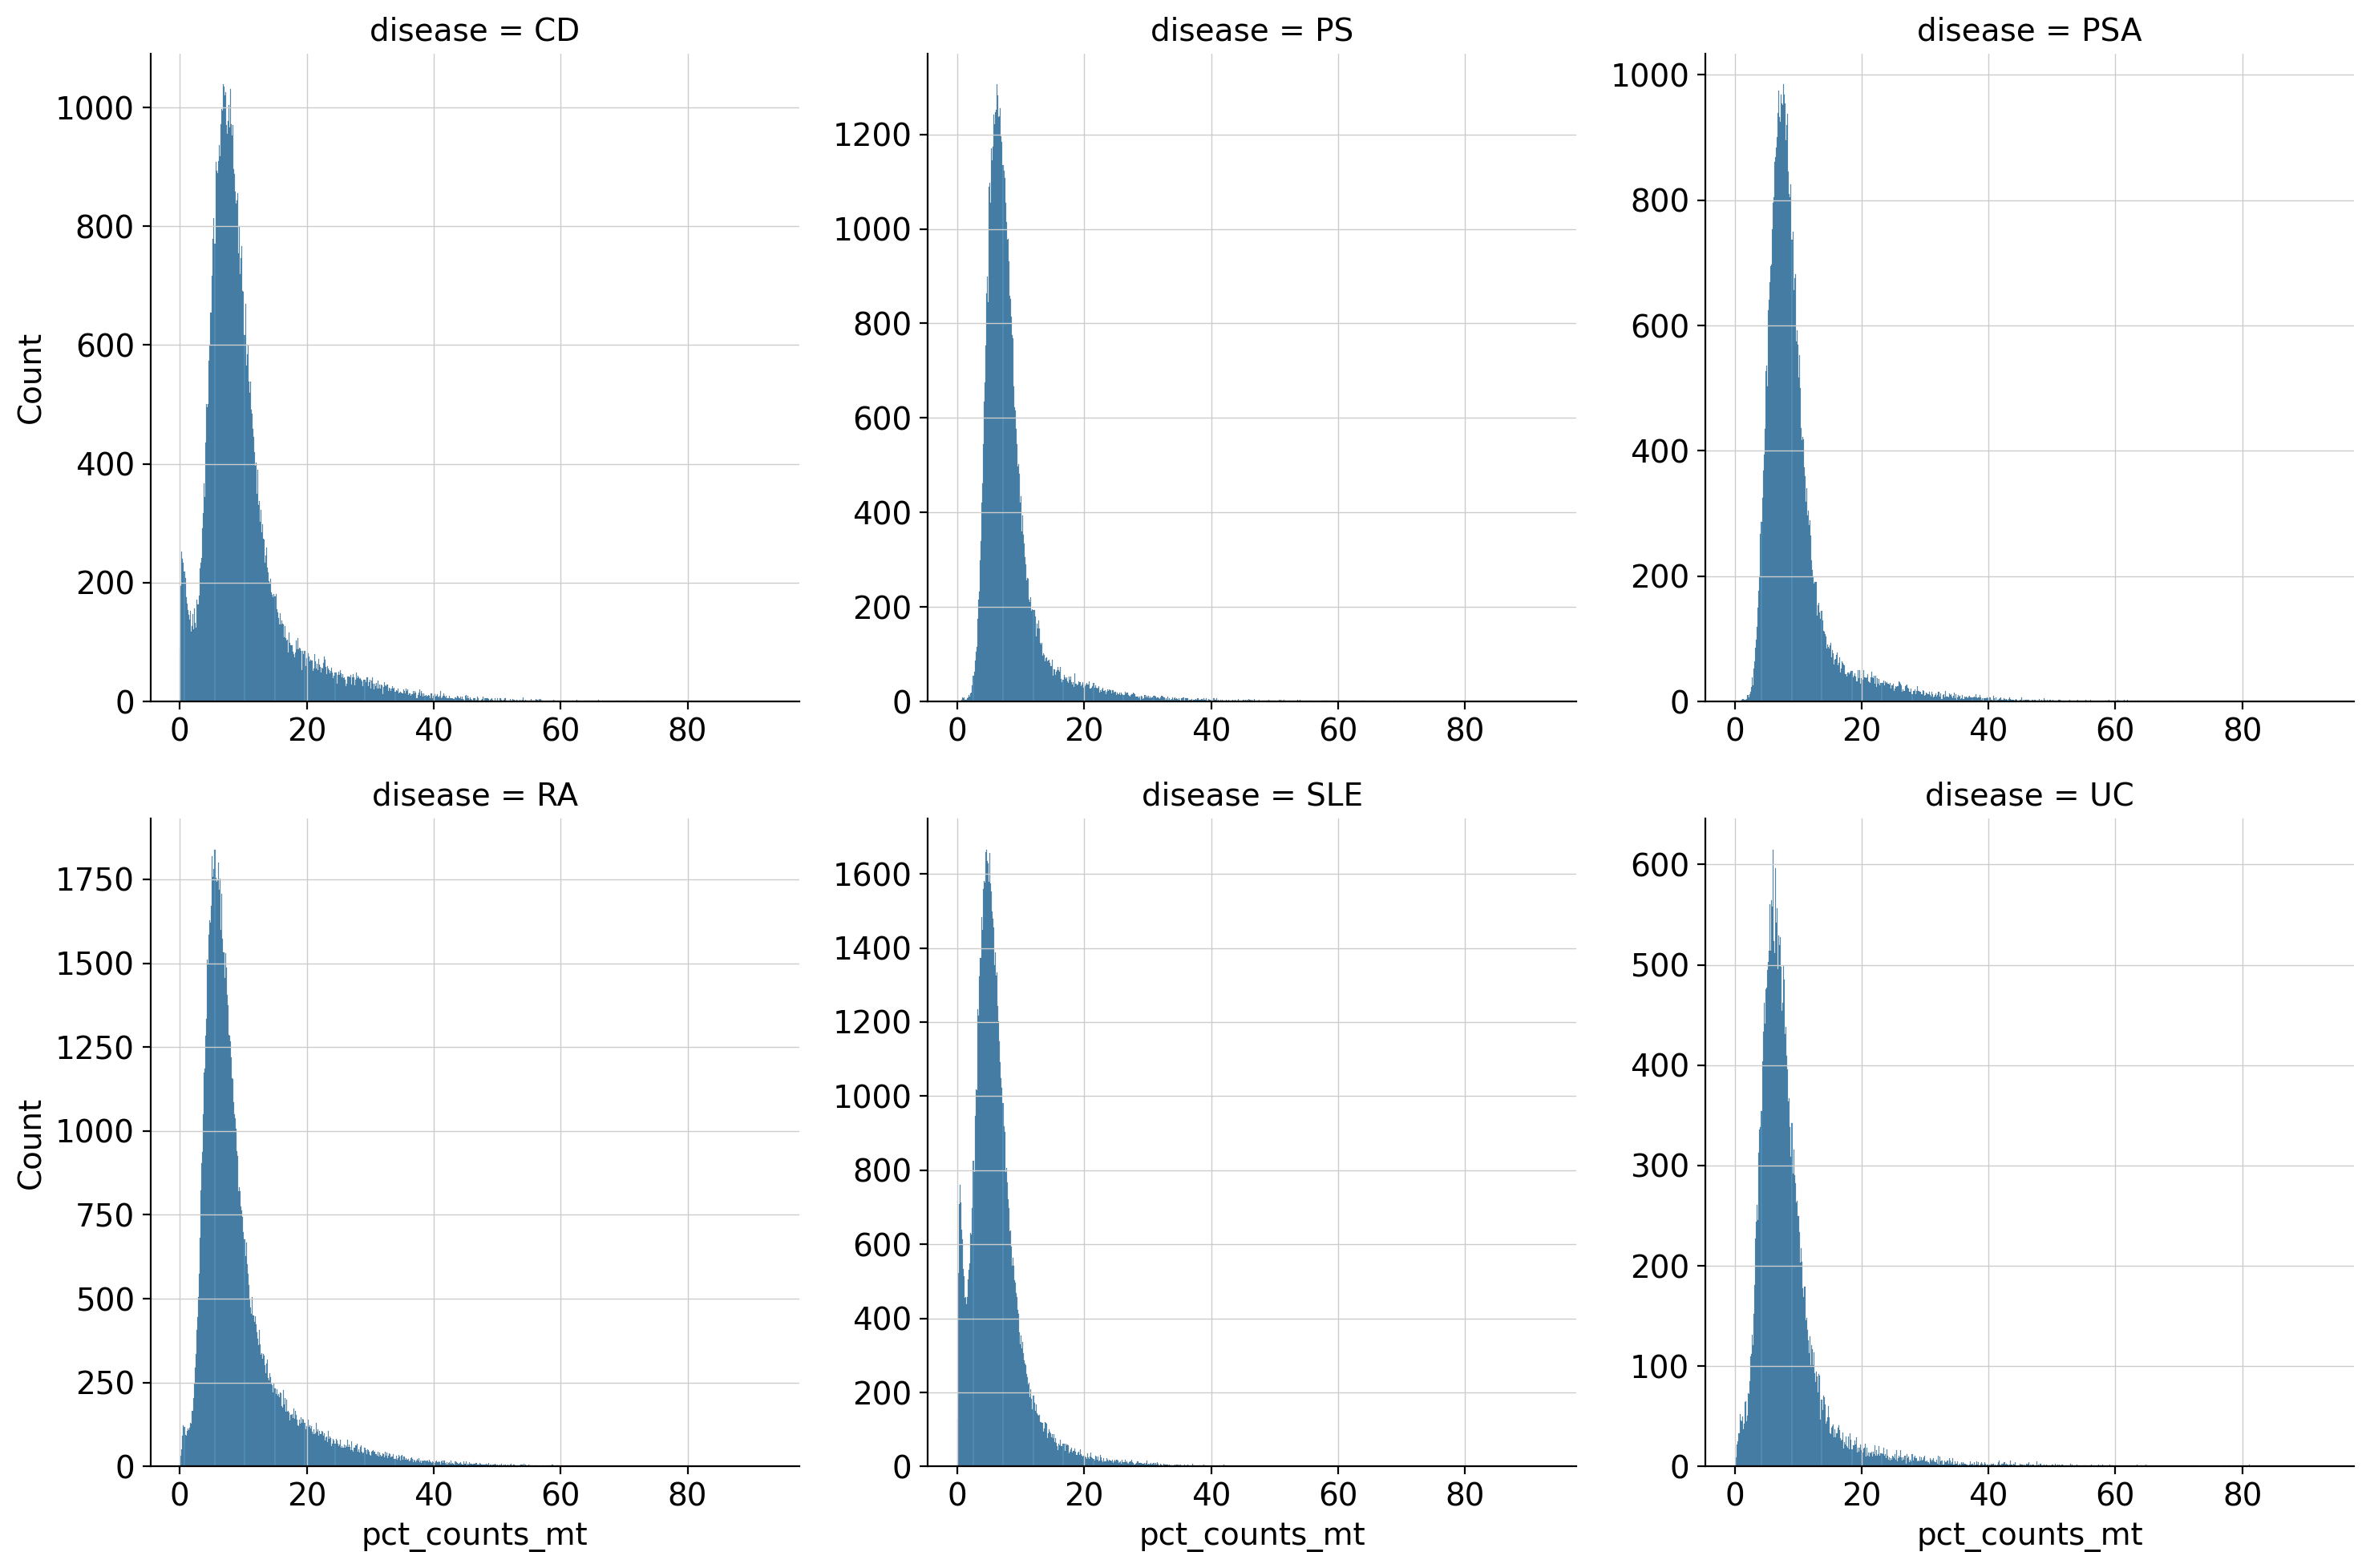

In [15]:
sns.displot(data=adata.obs, x="total_counts", col="disease", col_wrap=3, facet_kws={"sharex": False, "sharey": False})
if overwriteFigures:
    plt.savefig(here('01_data_processing/SCGT00_CentralizedDataset/figures/QC_EXTERNAL_metrics_displot_totalcounts_bydisease.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
plt.show()


sns.displot(data=adata.obs, x="n_genes_by_counts", col="disease", col_wrap=3, facet_kws={"sharex": False, "sharey": False})
if overwriteFigures:
    plt.savefig(here('01_data_processing/SCGT00_CentralizedDataset/figures/QC_EXTERNAL_metrics_displot_genesbycounts_bydisease.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
plt.show()


sns.displot(data=adata.obs, x="pct_counts_mt", col="disease", col_wrap=3, facet_kws={"sharex": False, "sharey": False})
if overwriteFigures:
    plt.savefig(here('01_data_processing/SCGT00_CentralizedDataset/figures/QC_EXTERNAL_metrics_displot_pctmt_bydisease.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
plt.show()

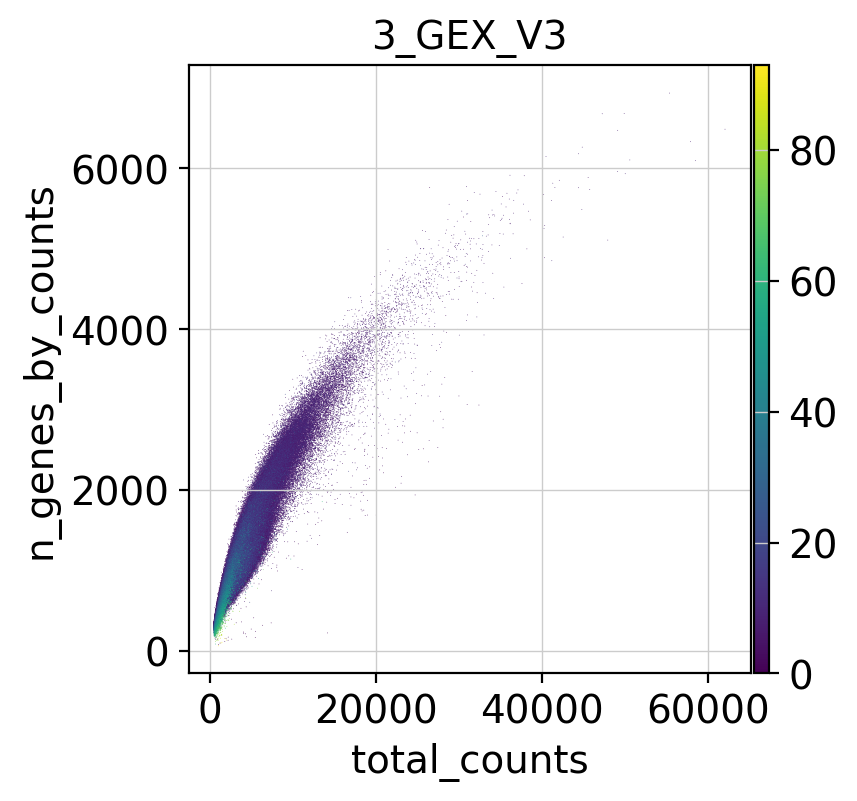

<Figure size 400x400 with 0 Axes>

In [16]:
cellIdx = (adata.obs.chemistry == "3_GEX_V3")
if np.sum(cellIdx) > 0:
    sc.pl.scatter(adata[cellIdx, :],
                  "total_counts", "n_genes_by_counts", color="pct_counts_mt", title="3_GEX_V3")
    if overwriteFigures:
        plt.savefig(here('01_data_processing/SCGT00_CentralizedDataset/figures/QC_EXTERNAL_joinmetrics_3GEXV3_beforeFiltering.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    plt.show()

After examining the previous results, we can see that the distribution of the three EXTERNAL QC covariates is really similar within the libraries generated using the same chemistry, and considering some datasets have already gone through a prior QC. For this reason, we will not perform a common QC for all of them, but split them by chemistry. 

It is important not to consider the QC covariates independently as this can lead to the misinterpretation of results, but to jointly explore how the three EXTERNAL metrics covary in order to set univariate QC thresholds. Additionally, it is also recommended to be quite permissive at this step and remove only very low quality cells, and later on, perform a second QC with more accurate and restrictive parameters (e.g. at the cell-lineage level).

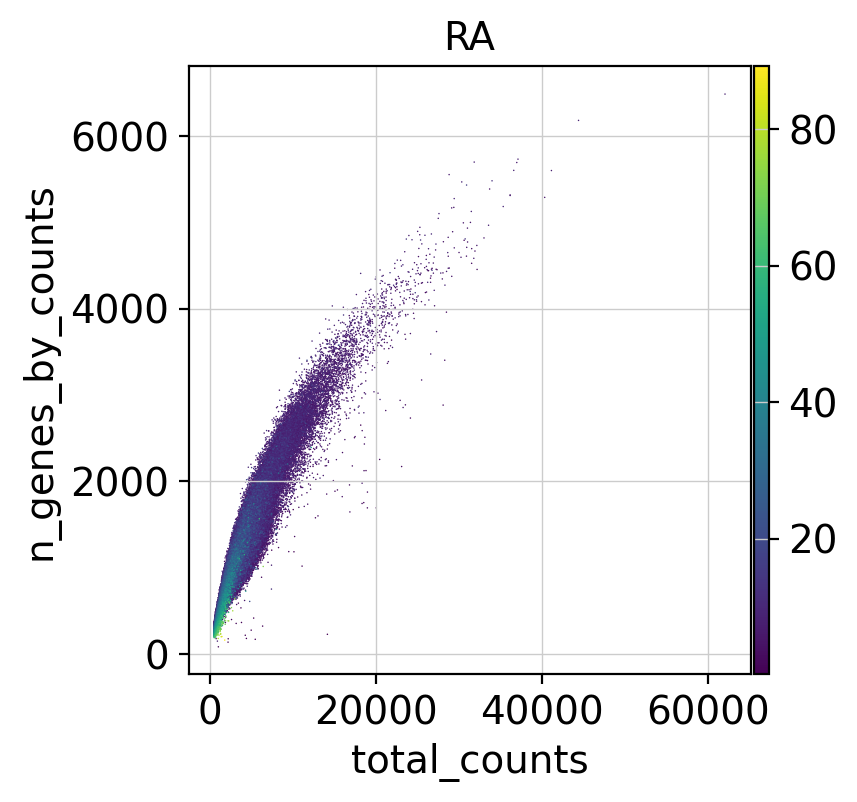

<Figure size 400x400 with 0 Axes>

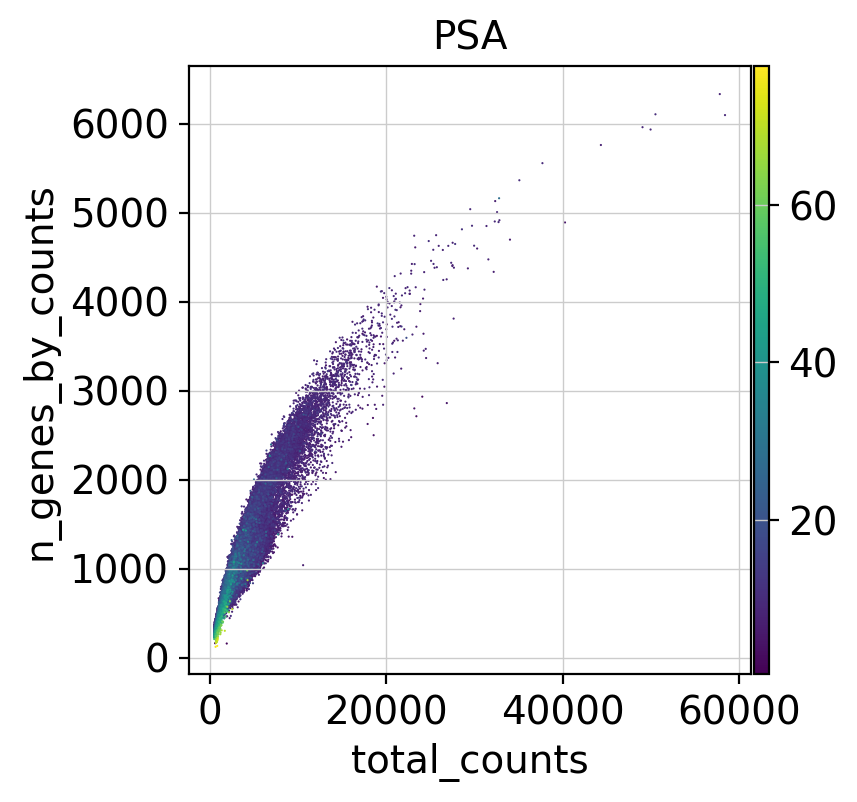

<Figure size 400x400 with 0 Axes>

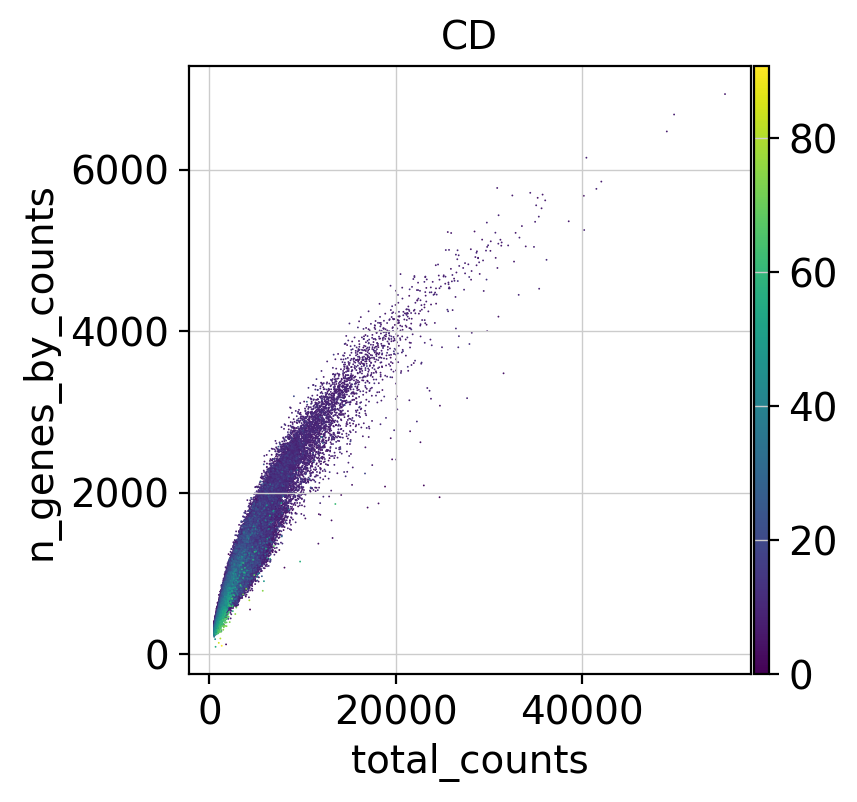

<Figure size 400x400 with 0 Axes>

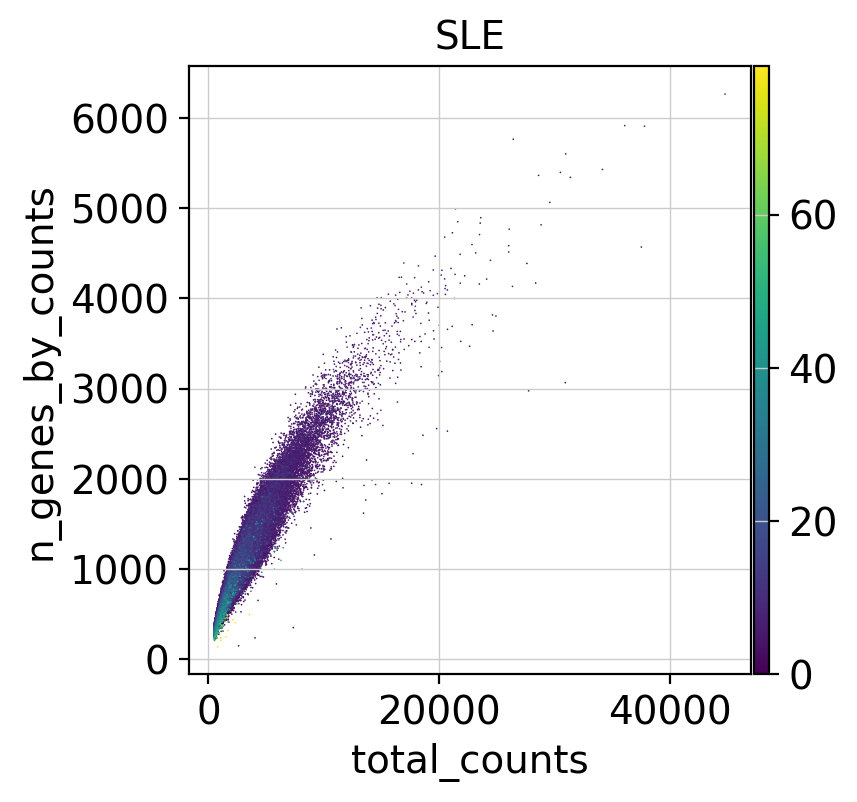

<Figure size 400x400 with 0 Axes>

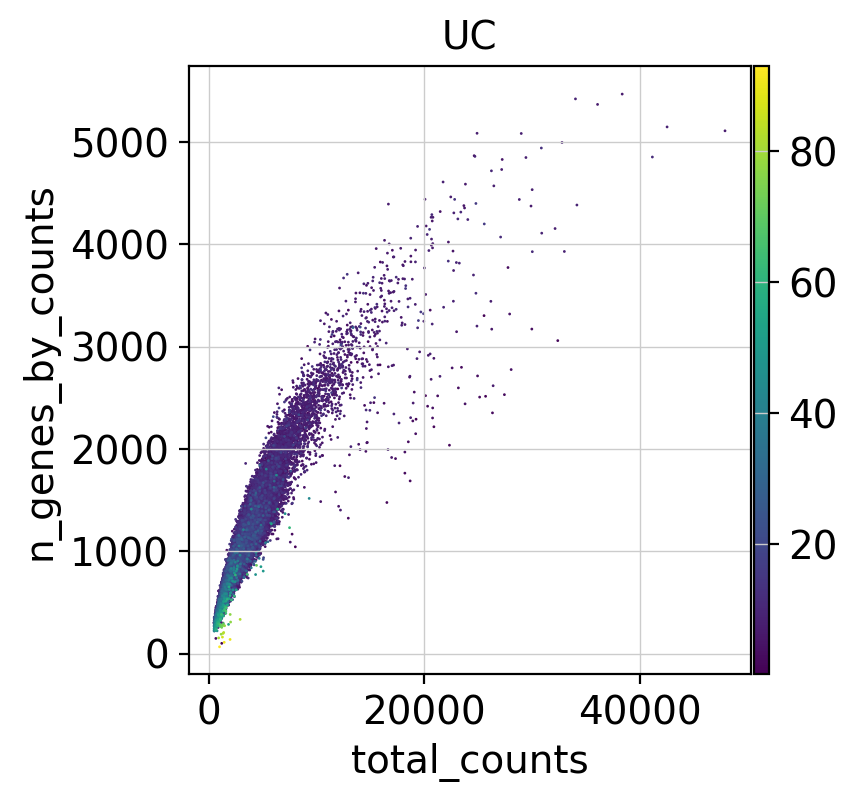

<Figure size 400x400 with 0 Axes>

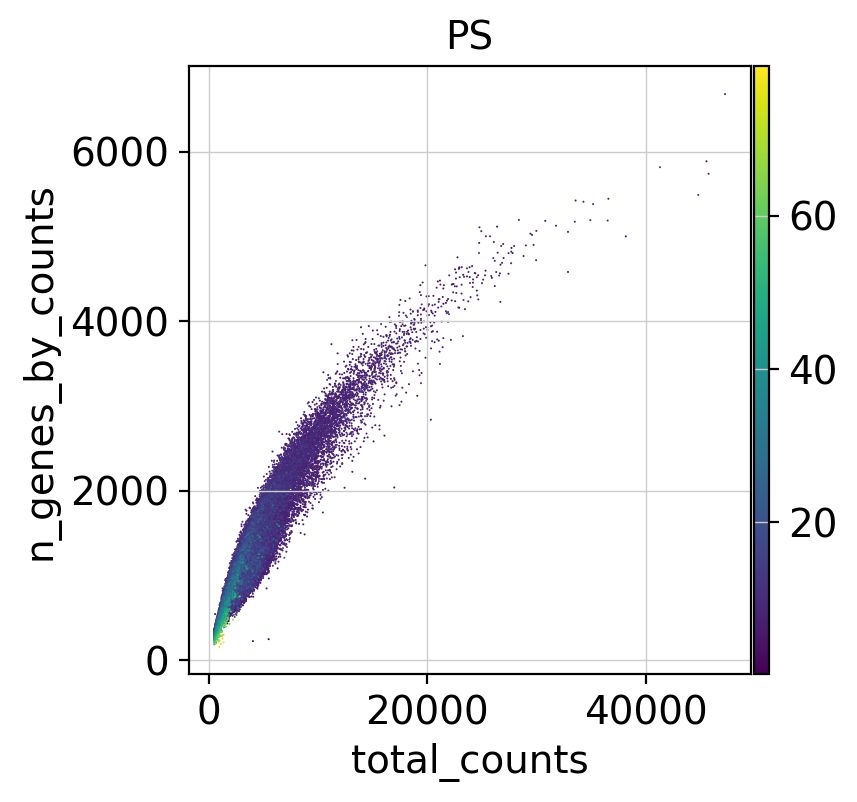

<Figure size 400x400 with 0 Axes>

In [17]:
for s in adata.obs.disease.unique():
    
    sc.pl.scatter(adata[adata.obs.disease == s, :],
                  "total_counts", "n_genes_by_counts", color="pct_counts_mt", title=s)
    
    if overwriteFigures:
        plt.savefig(here(f"01_data_processing/SCGT00_CentralizedDataset/figures/QC_EXTERNAL_joinmetrics_{s}.pdf"), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
        
    plt.show()    

## Filter out low quality cells

According to the previous results, we have decided to apply different thresholds according to technology. Basically, cell barcodes with a low count depth, few detected genes, and a high fraction of mitochondrial counts could be indicative of lysed cells; therefore, we will proceed to filter them out.

In [18]:
# QC thresholds

cell_qc_thresholds = {
    "3_GEX_V3": {
        "min_libsize": 500,
        "max_libsize": 50000,        
        "min_libcomplex": 250,
        "max_libcomplex": 6000,
        "max_pctmt": 25
    }
}

In [19]:
# Filter based on "chemistry" column
keepIDX = []

for chem_type, filter_params in cell_qc_thresholds.items():
    chem_filter = adata.obs["chemistry"] == chem_type
    chem_filter &= adata.obs["total_counts"] > filter_params["min_libsize"]
    chem_filter &= adata.obs["total_counts"] < filter_params["max_libsize"]
    chem_filter &= adata.obs["n_genes_by_counts"] > filter_params["min_libcomplex"]
    chem_filter &= adata.obs["n_genes_by_counts"] < filter_params["max_libcomplex"]
    chem_filter &= adata.obs["pct_counts_mt"] < filter_params["max_pctmt"]

    keepIDX += adata.obs.loc[chem_filter].index.tolist()

    # adata.append(adata[chem_filter])
    
adata = adata[adata.obs.index.isin(keepIDX)]
adata

View of AnnData object with n_obs × n_vars = 379359 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'disease_colors'

**General statistics AFTER cell QC**

In [20]:
pd.set_option('display.max_rows', None)
qc_gex_df = qc_gex_projectlibrary(adata)
display(qc_gex_df)

pd.reset_option('display.max_rows')

,libraryID,chemistry,Number of cells,Median UMI counts,Median Genes,Median MT %,Median RB %,Median HB %,Median PLT %
0,"(SCGT00_L003,)",[3_GEX_V3],27383,3572,1071,8.29,34.02,0.00,0.04
1,"(SCGT00_L010,)",[3_GEX_V3],27644,3717,1172,7.14,34.27,0.00,0.05
2,"(SCGT00_L013,)",[3_GEX_V3],19042,3479,1109,7.36,34.27,0.00,0.04
3,"(SCGT00_L016,)",[3_GEX_V3],20296,4345,1310,5.89,27.05,0.00,0.06
4,"(SCGT00_L024,)",[3_GEX_V3],28009,3526,1066,7.04,37.42,0.00,0.05
5,"(SCGT00_L026,)",[3_GEX_V3],24940,3615,1157,4.07,38.44,0.00,0.03
6,"(SCGT00_L028,)",[3_GEX_V3],25422,3793,1178,6.27,27.34,0.00,0.06
7,"(SCGT00_L030,)",[3_GEX_V3],28046,2876,942,8.39,30.72,0.00,0.04
8,"(SCGT00_L037,)",[3_GEX_V3],19982,3864,1185,6.65,36.73,0.00,0.04
9,"(SCGT00_L043,)",[3_GEX_V3],28044,2660,1019,5.75,29.45,0.00,0.04


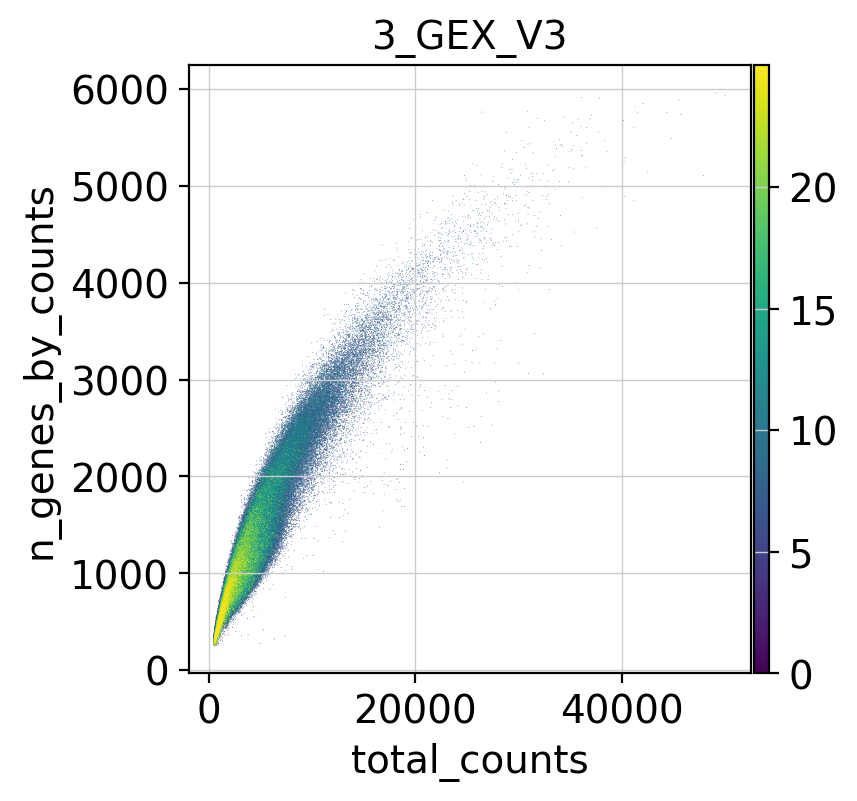

<Figure size 400x400 with 0 Axes>

In [21]:
cellIdx = (adata.obs.chemistry == "3_GEX_V3")
if np.sum(cellIdx) > 0:
    sc.pl.scatter(adata[cellIdx, :],
                  "total_counts", "n_genes_by_counts", color="pct_counts_mt", title="3_GEX_V3")
    if overwriteFigures:
        plt.savefig(here('01_data_processing/SCGT00_CentralizedDataset/figures/QC_EXTERNAL_joinmetrics_3GEXV3_afterFiltering.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    plt.show()


# Quality Control at (LIBRARY) & SAMPLE level

After exploring general library QC metrics, we decided to filter out the samples with very low number of cells, considering patient & timepoint, since some samples have been sequenced across multiple 10X libraries.

Also, after removing low quality cells, we ensure that there are now no low-quality library after removing low-quality cells, which would indicate low-quality library quality preparation and lead to a large batch-effect.

Lastly, we are removing cells that were captured in specific sample/library when the total number of cells belonging to this patient is smaller than 50 cells.

In [22]:
# QC thresholds
min_cells_by_sample = 500
min_meangenes_by_sample = 500
min_cells_by_samplelibrarypatient = 50

## Filter out low quality libraries

In [23]:
# Removing libraries with very low total number of cells (after cellQC)
min_cells_by_lib = 250

# Calculate the value counts for each 'libraryID'
library_cells = adata.obs["libraryID"].value_counts()

# Get the library names to remove
libraries_to_remove = library_cells[library_cells < min_cells_by_lib].index

if len(libraries_to_remove) > 0:
    print('Libraries removed:')
    print(libraries_to_remove.astype(str))

    # Filter the 'adata' object
    adata = adata[~adata.obs["libraryID"].isin(libraries_to_remove.astype(str))]
else:
    print('No library is removed')

No library is removed


## Filter out low quality samples

In [24]:
# Removing samples (patient & timepoint) with very low total number of cells

# Calculate the value counts for each 'sampleID'
sample_cells = adata.obs["sampleID"].value_counts()

# Get the sample names to remove
samples_to_remove = sample_cells[sample_cells < min_cells_by_sample].index

if len(samples_to_remove) > 0:
    print('Samples removed:')
    print(samples_to_remove.astype(str))

    # Filter the 'adata' object
    adata = adata[~adata.obs["sampleID"].isin(samples_to_remove.astype(str))]
else:
    print('No sample is removed')

No sample is removed


In [25]:
# Removing samples with very low median number of total genes

# Calculate the median total counts for each 'sampleID'
sample_median_counts = adata.obs.groupby("sampleID")["n_genes_by_counts"].median()

# Get the sample names with median "total_counts" fewer than 500
libraries_to_remove = sample_median_counts[sample_median_counts < min_meangenes_by_sample].index

if len(libraries_to_remove) > 0:
    print('Samples removed:')
    print(libraries_to_remove.astype(str))

    # Filter the 'adata' object
    adata = adata[~adata.obs["sampleID"].isin(libraries_to_remove.astype(str))]
else:
    print('No sample is removed')

No sample is removed


## Filtering cells from low quality samples / library by patient

In [26]:
samplelibpatients_cells = adata.obs[["sampleID", "libraryID", "patientID"]].value_counts().sort_values(ascending=True)
samplelibpatients_cells.head()

sampleID             libraryID    patientID    
SCGT00_I0142.3P_T0   SCGT00_L026  SCGT00_I0142      925
SCGT00_I11031.3P_T0  SCGT00_L044  SCGT00_I11031    1392
                     SCGT00_L052  SCGT00_I11031    1485
SCGT00_I0142.3P_T0   SCGT00_L043  SCGT00_I0142     1679
                     SCGT00_L046  SCGT00_I0142     1715
Name: count, dtype: int64

In [27]:
# Removing CELLS (sample & library & patient) with very low total number of cells

# Calculate the value counts
samplelibpatients_cells = adata.obs[["sampleID", "libraryID", "patientID"]].value_counts().sort_values(ascending=True)

if samplelibpatients_cells.min() <= min_cells_by_samplelibrarypatient: 
    # Get the sample names to remove
    cells_to_remove_df = samplelibpatients_cells[samplelibpatients_cells < min_cells_by_samplelibrarypatient]
    
    cells_to_remove_df = pd.DataFrame(cells_to_remove_df.reset_index())
    cells_to_remove_df["libraryID"] = cells_to_remove_df["libraryID"].astype(str)
    cells_to_remove_df["sampleID"] = cells_to_remove_df["sampleID"].astype(str)
    cells_to_remove_df['startwith_cellID'] = cells_to_remove_df["libraryID"] + '_' + cells_to_remove_df["sampleID"].str.split("_", expand=True)[1] + '_' + cells_to_remove_df["sampleID"].str.split("_", expand=True)[2]

    if len(cells_to_remove_df) > 0:
    
        cellID_to_remove = [cell_id for cell_id in adata.obs_names if any(cell_id.startswith(startwith) 
                                 for startwith in cells_to_remove_df["startwith_cellID"])]
        print('Cells from samples/library/patient removed:')
        print(len(cellID_to_remove))
        print(cellID_to_remove)
    
        # Filter the 'adata' object
        adata = adata[~adata.obs_names.isin(cellID_to_remove)]
else:
    print('No cells from samples/library/patient are removed.')

No cells from samples/library/patient are removed.


In [28]:
adata

View of AnnData object with n_obs × n_vars = 379359 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'disease_colors'

In [29]:
len(adata.obs["sampleID"].unique())

56

# Save results

In [30]:
# Save Anndata object (.h5ad file) 
adata.write(here("01_data_processing/SCGT00_CentralizedDataset/results/SCGT00_EXTERNAL_afterQC.h5ad"), compression="gzip")
del adata

In [31]:
session_info.show()